In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from datetime import timedelta
from sklearn.linear_model import LinearRegression

In [2]:
def bootstrap_regression(df, name, graph="no"):
    
    df_temp = df.copy()
    df_temp = df_temp[df_temp["Punten Resultaat"] > 0]

    X = df.drop(columns=[
        "Favoriete onderdeel", "Discipline",  "Geslacht", "Naam", "Land", "Specialiteit", "Week",
        "AtleetID", "Leeftijd", "MaxID", "Resultaat", "Punten Resultaat", "Resultaat geconverteerd"])
    y = df["Punten Resultaat"]

    # Aantal bootstrap samples
    n_iterations = 1000
    coefs = []

    for _ in range(n_iterations):
        # Bootstrap sample trekken
        X_resampled, y_resampled = resample(X, y)
        
        # Model trainen
        model = LinearRegression()
        model.fit(X_resampled, y_resampled)
        
        # Coëfficiënten opslaan
        coefs.append(model.coef_)

    # Zet resultaten om in een DataFrame
    coefs_df = pd.DataFrame(coefs, columns=X.columns)

    # Bereken gemiddeldes en standaarddeviaties
    mean_coefs = coefs_df.mean()
    std_coefs = coefs_df.std()

    if graph == "yes":
        plt.figure(figsize=(10, 6))
        plt.bar(mean_coefs.index, mean_coefs, yerr=std_coefs, capsize=5, alpha=0.75)
        plt.xticks(rotation=45) 
        plt.ylabel("Gemiddelde Coëfficiënt")
        plt.title(name)
        plt.grid(axis='y')
        plt.show()  

    return [(feature, round(mean_coefs[feature], 2), round(std_coefs[feature], 2)) for feature in X.columns]


# Functie om afstand/tijd correct om te zetten
def convert_value(value):
    value = str(value).strip()  # Zorg dat het een string is en geen spaties bevat
    
    # 1. Controleer of het een afstand is (bijv. '0.55 m')
    if "m" in value and ":" not in value:
        return float(value.replace("m", "").strip())  # Zet om naar float
    
    # 2. Controleer of het een tijd in seconden is (bijv. '14.68 s')
    if "s" in value:
        return float(timedelta(seconds=float(value.replace("s", "").strip())).total_seconds())  # Zet om naar timedelta
    
    # 3. Controleer of het een tijd in het formaat '1h:03:29.63' is
    if "h:" in value:
        hours, rest = value.split("h:")
        minutes, seconds = rest.split(":")
        return float(timedelta(hours=int(hours), minutes=int(minutes), seconds=float(seconds)).total_seconds())
    
    # 4. Controleer of het een tijd in het formaat '1:02.18' is (minuten:seconden)
    if re.match(r"^\d+:\d+\.\d+$", value):
        minutes, seconds = value.split(":")
        return float(timedelta(minutes=int(minutes), seconds=float(seconds)).total_seconds())
    
    return None  # Onbekend formaat

In [3]:
df = pd.read_csv('data/database.csv')
df["Is Favorite"] = df["Favoriete onderdeel"] == df["Discipline"]
df["Resultaat geconverteerd"] = df["Resultaat"].apply(convert_value)
df_filtered = df.drop(columns=["Resultaat geconverteerd", "Humeur", "Resultaat", "Favoriete onderdeel", "Specialiteit", "Land", "Naam", "AtleetID", "MaxID", "Week", "Geslacht"])	
df_filtered

df_filtered.describe()

,Leeftijd,Ervaring,Vorm,Lengte,Gewicht,Zorg,Kracht,Uithouding,Snelheid,Lenigheid,Springen,Werpen,SP1,SP2,Punten Resultaat
count,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000,27982.000000
mean,21.180009,4.040097,15.393860,173.836931,72.781324,14.236795,4.545386,3.965799,5.546423,3.956115,3.599600,3.486098,7.354156,7.325316,504.656386
std,6.976939,4.690778,1.896487,9.488869,11.963427,4.247132,4.039165,4.379737,4.622465,3.345983,3.684416,3.486705,2.306647,2.278708,276.874113
min,14.000000,1.000000,10.000000,146.000000,32.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,17.000000,1.000000,14.000000,167.000000,64.000000,11.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,6.000000,6.000000,328.000000
50%,17.000000,1.000000,15.000000,174.000000,72.000000,15.000000,3.000000,2.000000,4.000000,3.000000,2.000000,2.000000,7.000000,7.000000,543.000000
75%,25.000000,6.000000,17.000000,181.000000,81.000000,18.000000,7.000000,5.000000,9.000000,6.000000,5.000000,5.000000,9.000000,9.000000,693.000000
max,47.000000,20.000000,20.000000,202.000000,133.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,18.000000,20.000000,1198.000000


In [4]:
df["Discipline"].value_counts()

Discipline
Kogelslingeren                         1056
Speerwerpen                            1056
Kogelstoten                            1056
Discuswerpen                           1056
400 meter                              1015
200 meter                              1015
100 meter                              1015
400 meter horden                       1015
Polsstokhoogspringen                    980
Hoogspringen                            980
Hinkstapspringen                        980
Verspringen                             980
20 km snelwandelen                      721
10 km snelwandelen                      721
50 km snelwandelen                      721
5.000 meter                             689
10.000 meter                            689
Marathon                                689
1.500 meter                             688
800 meter                               688
3.000 meter steeplechase                688
110 meter horden                        535
100 meter horden     

Mean Squared Error: 758.9179
R-squared: 0.9859


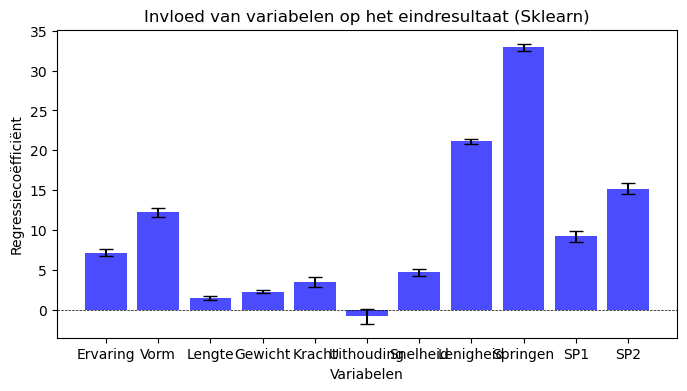

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def analyse_invloed(df, target_column):
    """
    Voert een lineaire regressie uit met sklearn en voegt errorbars toe.
    
    Parameters:
    df (pd.DataFrame): DataFrame met onafhankelijke variabelen en een doelvariabele.
    target_column (str): Naam van de kolom die het eindresultaat bevat.
    
    Retourneert:
    - Samenvatting van de regressieanalyse
    - Grafiek met coëfficiënten en errorbars
    """
    
    # Splits onafhankelijke variabelen en doelvariabele
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Split de data in trainings- en testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
    
    # Pas lineaire regressie toe met sklearn
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Voorspellingen maken
    y_pred = model.predict(X_test)
    
    # Evaluatie van het model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    # Bereken standaardfouten van de coëfficiënten
    X_train_with_const = np.c_[np.ones(X_train.shape[0]), X_train]
    y_train_pred = model.predict(X_train)
    residuals = y_train - y_train_pred
    mse_train = np.mean(residuals**2)
    cov_matrix = mse_train * np.linalg.inv(X_train_with_const.T @ X_train_with_const)
    std_errors = np.sqrt(np.diag(cov_matrix)[1:])  # Eerste waarde overslaan (constante)
    
    # Plot de coëfficiënten met errorbars
    coef = model.coef_
    plt.figure(figsize=(8, 4))
    plt.bar(X.columns, coef, yerr=std_errors, color='blue', alpha=0.7, capsize=5)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
    plt.title('Invloed van variabelen op het eindresultaat (Sklearn)')
    plt.ylabel('Regressiecoëfficiënt')
    plt.xlabel('Variabelen')
    plt.show()
    
    return model

# Voorbeeldgebruik:
if __name__ == "__main__":
    df_temp = df_filtered.copy()

    df_temp = df_temp[(df_temp["Punten Resultaat"] > 0) & (df_temp["Discipline"] == "Hoogspringen") & (df_temp["Is Favorite"] == False)]


    # Definieer de onafhankelijke variabelen (features) en de afhankelijke variabele (resultaat)
    df_temp.drop(columns=["Discipline", "Is Favorite", "Leeftijd", "Zorg", "Werpen"], inplace=True)  # Vervang 'resultaat' met de naam van je afhankelijke variabele
    analyse_invloed(df_temp, 'Punten Resultaat')